In [59]:
import os
import json
import numpy as np
import torch
import matplotlib.pyplot as plt


In [ ]:
def load_meta_data(json_path):
    with open(json_path, 'r') as f:
        meta = json.load(f)
    return meta

In [ ]:
def load_iq_bin(bin_path, json_path):
    with open(json_path, 'r') as f:
        meta = json.load(f)

    dtype_map = {
        "int16": np.int16,
        "int32": np.int32,
        "float32": np.float32
    }

    dtype = dtype_map.get(meta.get("data_type", "int16"))
    if dtype is None:
        raise ValueError(f"Unsupported data type: {meta.get('data_type')}")

    interleaved = meta.get("interleaved", True)
    raw = np.fromfile(bin_path, dtype=dtype)

    if interleaved:
        if len(raw) % 2 != 0:
            raise ValueError("Data length is not even; cannot interleave I/Q.")
        iq = raw[::2] + 1j * raw[1::2]
    else:
        raise NotImplementedError("Non-interleaved format not supported.")

    #return iq, meta.get("sample_rate", 1.0)
    return iq, meta.get("sampling_frequency", 61440000.0)


In [61]:
def torch_stft(iq_tensor, window_size=1024, hop_size=256):
    frames = iq_tensor.unfold(0, window_size, hop_size)
    spectrum = torch.fft.fft(frames, dim=1)
    #spectrum = torch.fft.fftshift(spectrum, dim=1)
    return spectrum


In [62]:
def save_spectrogram(iq_data, output_path, fs=1.0, window_size=1024, hop_size=256):
    iq_tensor = torch.tensor(iq_data, dtype=torch.complex64)
    spec = torch_stft(iq_tensor, window_size=window_size, hop_size=hop_size)
    power_dB = 20 * torch.log10(torch.abs(spec) + 1e-10)
    np.save(output_path, power_dB.cpu().numpy())
    print(f"Saved spectrogram: {output_path}")


In [ ]:
def plot_example(spec_path):
    spec = np.load(spec_path)
    plt.figure(figsize=(11, 5))
    plt.imshow(spec.T, aspect='auto', origin='lower')
    plt.title("Spectrogram (dB)")
    plt.xlabel("Time Frames")
    plt.ylabel("Frequency Bins")
    plt.colorbar(label="Power (dB)")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='svg', dpi=300)  # or 'pdf' or 'eps'
    plt.show()


Saved spectrogram: ./npy_data/output_spectrogram.npy


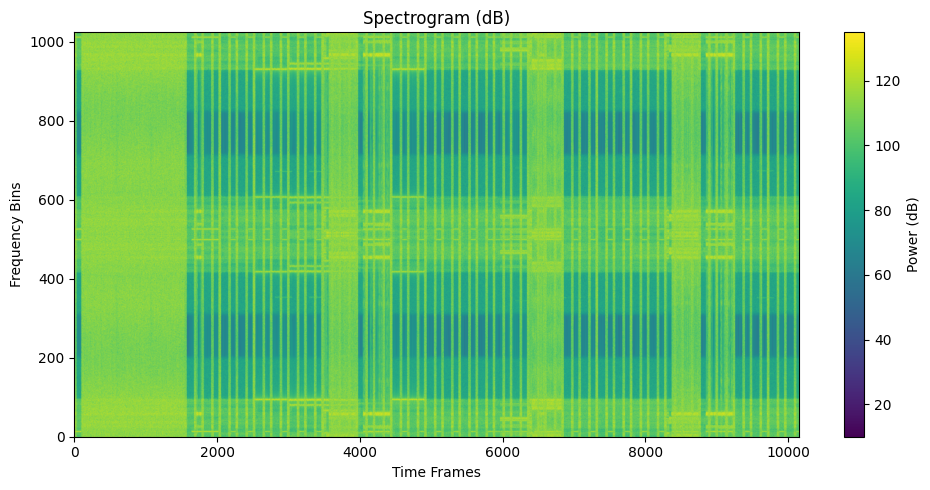

In [64]:
# Change these to your actual file paths
bin_file = "./IQ_Data/27_LTE_1/bin/IQ_2024-04-19T15-31-17_743444552.bin"
json_file = "./IQ_Data/27_LTE_1/IQ_2024-04-19T15-31-17_743444552.json"
output_file = "./npy_data/output_spectrogram.npy"

# Ensure output directory exists
os.makedirs(os.path.dirname(output_file), exist_ok=True)

# Run the pipeline
iq_data, fs = load_iq_bin(bin_file, json_file)
save_spectrogram(iq_data, output_file, fs=fs)
plot_example(output_file)
